In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
    confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
import joblib
import warnings
warnings.filterwarnings('ignore')
from time import time
from sklearn.tree import DecisionTreeClassifier


### step 1: Load and Split Data

In [3]:
print("Loading data...")
df = pd.read_csv('engineered_dataset.csv')

X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Loading data...


### step 2: Random Forest and Gradient Boosting Tuning

In [4]:
# Updated parameters focusing on the most promising ranges
rf_params = {
    'n_estimators': [200, 300, 400],  # More trees
    'max_depth': [20, 25, 30],        # Deeper trees
    'min_samples_split': [2, 3],      # More conservative splitting
    'min_samples_leaf': [1, 2],       # Keep leaves small
    'max_features': ['sqrt', 'log2']   # Standard feature selection
}

gb_params = {
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.08, 0.1],  # Finer learning rate control
    'max_depth': [4, 5, 6],              # Slightly deeper trees
    'min_samples_split': [2, 3],
    'subsample': [0.8, 0.9]              # Prevent overfitting
}

ada_params = {
    'n_estimators': [100, 150, 200],     # Focus on medium-size ensembles
    'learning_rate': [0.8, 1.0],         # Higher learning rates worked better
    'algorithm': ['SAMME','SAMME.R']             # Stick with better performing algorithm
}

### step 3: functions for modelling and eval

In [5]:
def tune_and_evaluate(model, param_grid, X_train, X_test, y_train, y_test, model_name, max_time=300):
    """
    Perform hyperparameter tuning with time limit
    """
    print(f"\nTuning {model_name}...")
    start_time = time()
    
    # Initialize RandomizedSearchCV with more iterations
    random_search = RandomizedSearchCV(
    model, param_grid, 
    n_iter=25,                         # More iterations
    cv=5,                              # Keep 5-fold CV
    scoring='balanced_accuracy',        # Use balanced accuracy
    n_jobs=-1,
    random_state=42
)
    
    # Fit with timeout
    random_search.fit(X_train, y_train)
    
    print(f"Time taken: {time() - start_time:.2f} seconds")
    
    # Get best model and make predictions
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate all metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }
    
    return best_model, metrics, random_search.best_params_

### step 4: model boosting

In [6]:
tuning_results = {}

print("\nStarting Random Forest tuning...")
rf_model = RandomForestClassifier(random_state=42)
best_rf, rf_metrics, rf_best_params = tune_and_evaluate(
    rf_model, rf_params, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest"
)
tuning_results['Random Forest'] = {'metrics': rf_metrics, 'best_params': rf_best_params}
print("Random Forest tuning completed")

print("\nStarting Gradient Boosting tuning...")
gb_model = GradientBoostingClassifier(random_state=42)
best_gb, gb_metrics, gb_best_params = tune_and_evaluate(
    gb_model, gb_params, X_train_scaled, X_test_scaled, y_train, y_test, "Gradient Boosting"
)
tuning_results['Gradient Boosting'] = {'metrics': gb_metrics, 'best_params': gb_best_params}
print("Gradient Boosting tuning completed")

print("\nStarting AdaBoost tuning...")
ada_model = AdaBoostClassifier(random_state=42)
best_ada, ada_metrics, ada_best_params = tune_and_evaluate(
    ada_model, ada_params, X_train_scaled, X_test_scaled, y_train, y_test, "AdaBoost"
)
tuning_results['AdaBoost'] = {'metrics': ada_metrics, 'best_params': ada_best_params}
print("AdaBoost tuning completed")



Starting Random Forest tuning...

Tuning Random Forest...
Time taken: 26.44 seconds
Random Forest tuning completed

Starting Gradient Boosting tuning...

Tuning Gradient Boosting...
Time taken: 57.51 seconds
Gradient Boosting tuning completed

Starting AdaBoost tuning...

Tuning AdaBoost...
Time taken: 4.45 seconds
AdaBoost tuning completed


### step 5: Compare base vs tuned models


Detailed Model Performance Comparison:
--------------------------------------------------
               Model  Base Accuracy  Base Precision  Base Recall  Base F1  \
0      Random Forest         0.8844          0.8904       0.8633   0.8766   
1  Gradient Boosting         0.8883          0.8951       0.8668   0.8807   
2           AdaBoost         0.8856          0.8897       0.8668   0.8781   

   Base ROC-AUC  Tuned Accuracy  Tuned Precision  Tuned Recall  Tuned F1  \
0        0.9548          0.8894           0.8944        0.8703    0.8822   
1        0.9589          0.8883           0.8951        0.8668    0.8807   
2        0.9501          0.8856           0.8888        0.8680    0.8783   

   Tuned ROC-AUC  Accuracy Improvement  Precision Improvement  \
0         0.9558                0.0050                 0.0040   
1         0.9603                0.0000                 0.0000   
2         0.9526                0.0000                -0.0009   

   Recall Improvement  F1 Improvem

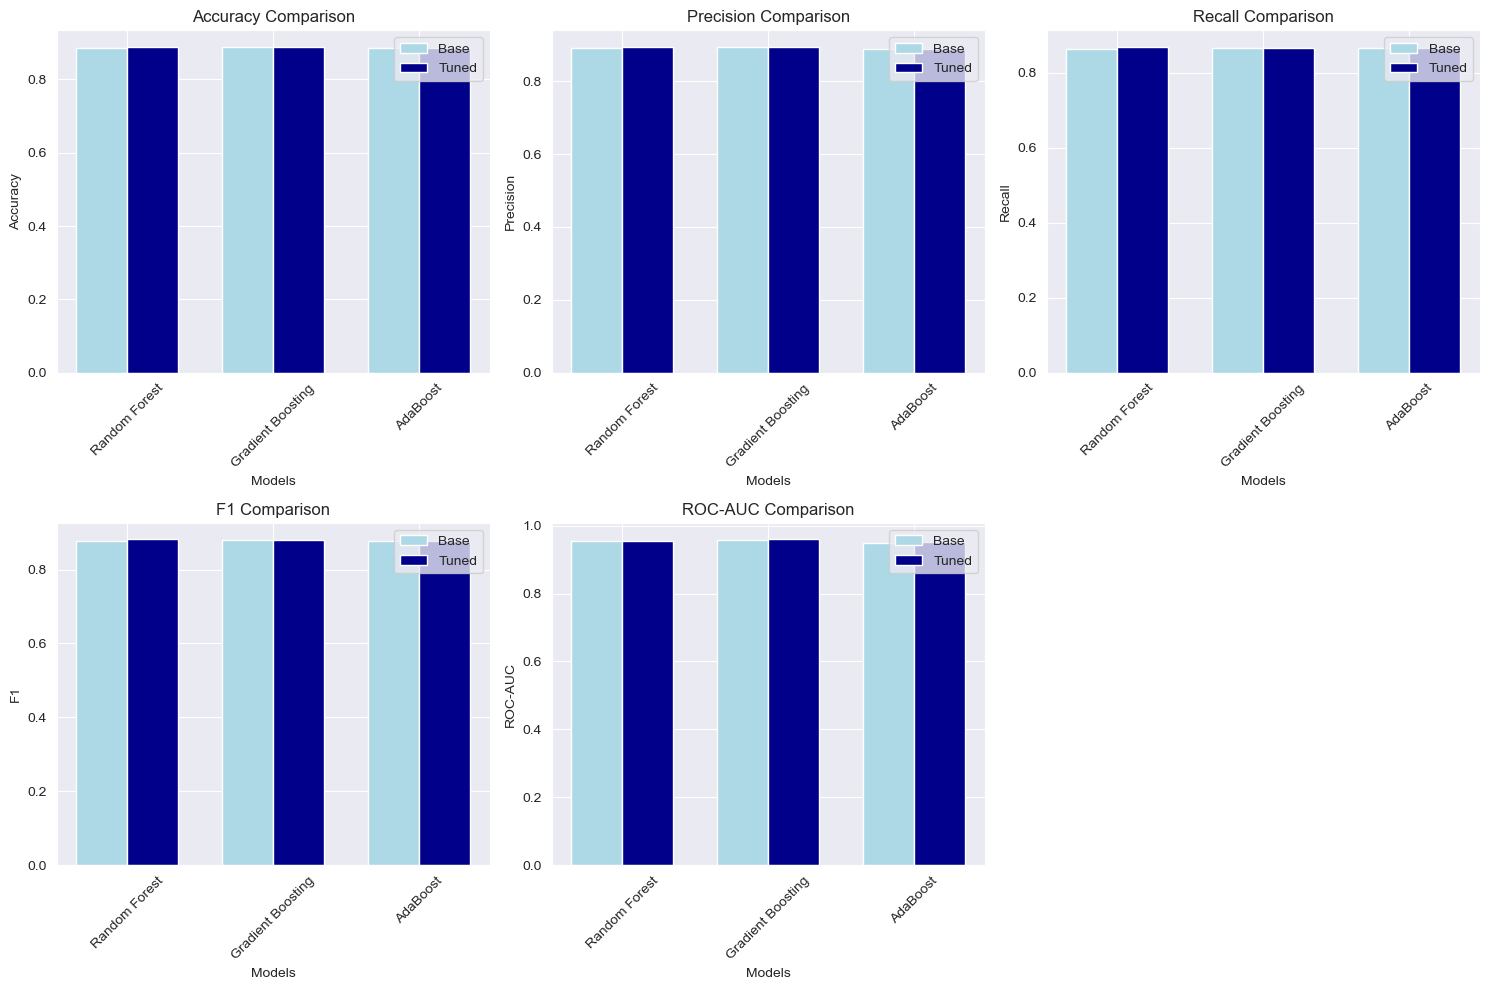

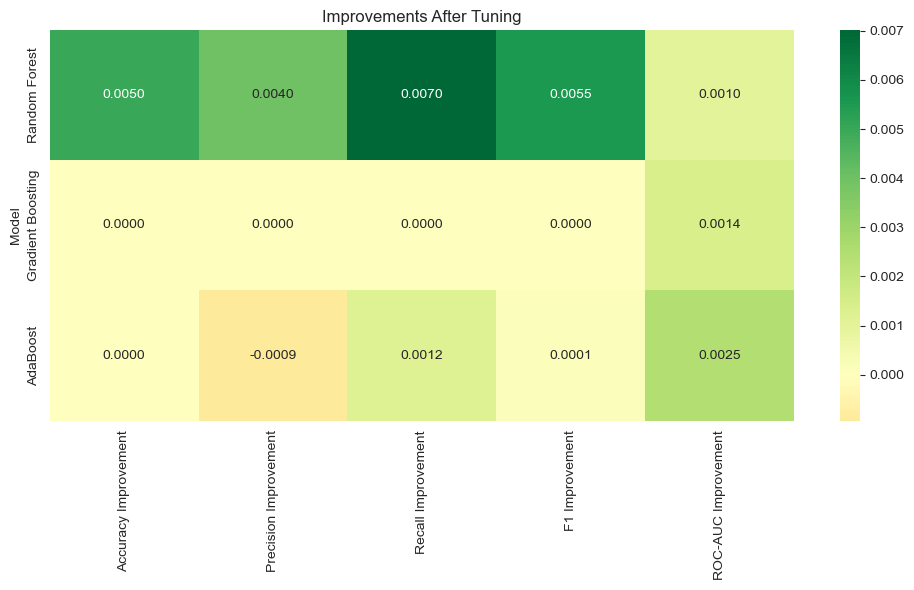


Detailed Summary of Improvements:
--------------------------------------------------

Random Forest:
Accuracy: 0.50% improvement
  Base: 0.8844
  Tuned: 0.8894
Precision: 0.40% improvement
  Base: 0.8904
  Tuned: 0.8944
Recall: 0.70% improvement
  Base: 0.8633
  Tuned: 0.8703
F1: 0.55% improvement
  Base: 0.8766
  Tuned: 0.8822
ROC-AUC: 0.10% improvement
  Base: 0.9548
  Tuned: 0.9558

Gradient Boosting:
Accuracy: 0.00% improvement
  Base: 0.8883
  Tuned: 0.8883
Precision: 0.00% improvement
  Base: 0.8951
  Tuned: 0.8951
Recall: 0.00% improvement
  Base: 0.8668
  Tuned: 0.8668
F1: 0.00% improvement
  Base: 0.8807
  Tuned: 0.8807
ROC-AUC: 0.14% improvement
  Base: 0.9589
  Tuned: 0.9603

AdaBoost:
Accuracy: 0.00% improvement
  Base: 0.8856
  Tuned: 0.8856
Precision: -0.09% improvement
  Base: 0.8897
  Tuned: 0.8888
Recall: 0.12% improvement
  Base: 0.8668
  Tuned: 0.8680
F1: 0.01% improvement
  Base: 0.8781
  Tuned: 0.8783
ROC-AUC: 0.25% improvement
  Base: 0.9501
  Tuned: 0.9526

Comp

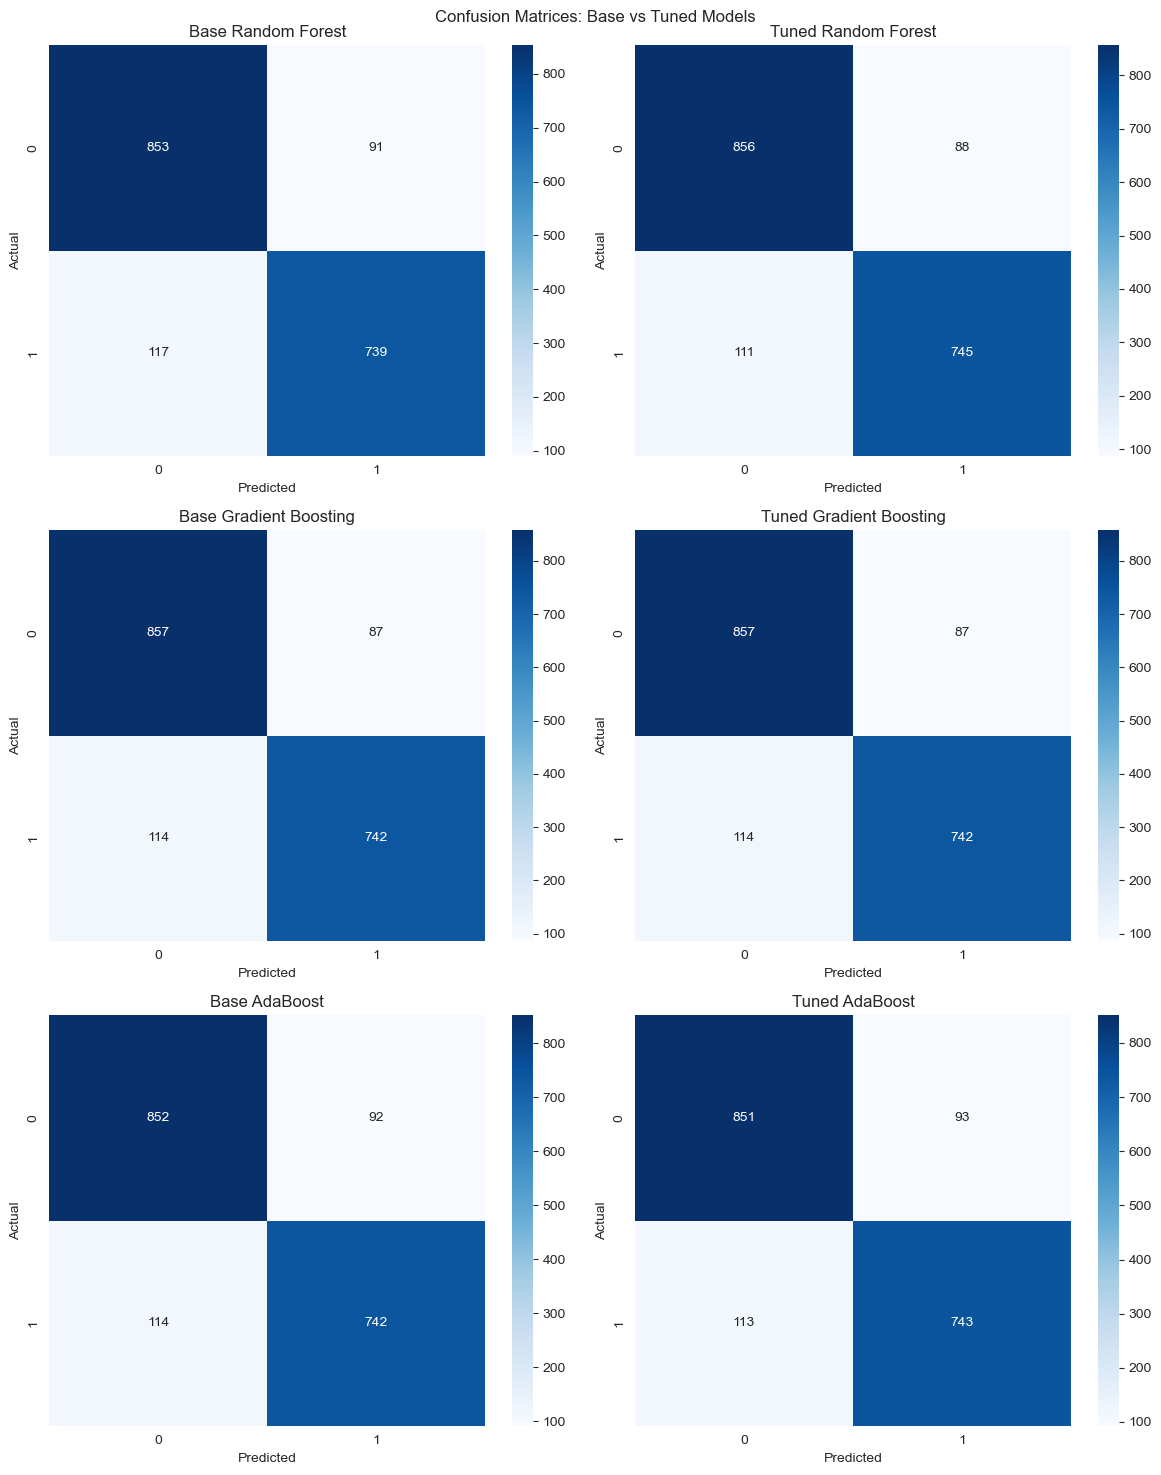

In [7]:
# %% md
### Step 5: Comprehensive Comparison of Base vs Tuned Models Performance
# %%
# Load base models from part 5
base_rf = joblib.load('random_forest_model.joblib')
base_gb = joblib.load('gradient_boosting_model.joblib')
base_ada = joblib.load('adaboost_model.joblib')

# Create dictionary of base and tuned models
models_comparison = {
    'Random Forest': {'base': base_rf, 'tuned': best_rf},
    'Gradient Boosting': {'base': base_gb, 'tuned': best_gb},
    'AdaBoost': {'base': base_ada, 'tuned': best_ada}
}

# Function to calculate all metrics
def calculate_metrics(y_true, y_pred, y_pred_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba)
    }

# Compare performance
comparison_data = []
for name, models in models_comparison.items():
    # Base model predictions
    base_pred = models['base'].predict(X_test_scaled)
    base_pred_proba = models['base'].predict_proba(X_test_scaled)[:, 1]
    base_metrics = calculate_metrics(y_test, base_pred, base_pred_proba)
    
    # Tuned model predictions
    tuned_pred = models['tuned'].predict(X_test_scaled)
    tuned_pred_proba = models['tuned'].predict_proba(X_test_scaled)[:, 1]
    tuned_metrics = calculate_metrics(y_test, tuned_pred, tuned_pred_proba)
    
    # Calculate improvements
    improvements = {
        f'{metric} Improvement': tuned_metrics[metric] - base_metrics[metric]
        for metric in base_metrics.keys()
    }
    
    comparison_data.append({
        'Model': name,
        **{f'Base {k}': v for k, v in base_metrics.items()},
        **{f'Tuned {k}': v for k, v in tuned_metrics.items()},
        **improvements
    })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display results
print("\nDetailed Model Performance Comparison:")
print("-" * 50)
pd.set_option('display.float_format', '{:.4f}'.format)
print(comparison_df.round(4))

# Create visualization of all metrics
plt.figure(figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
n_metrics = len(metrics)

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    x = np.arange(len(comparison_df))
    width = 0.35
    
    plt.bar(x - width/2, comparison_df[f'Base {metric}'], width, 
            label='Base', color='lightblue')
    plt.bar(x + width/2, comparison_df[f'Tuned {metric}'], width, 
            label='Tuned', color='darkblue')
    
    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(x, comparison_df['Model'], rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

# Create heatmap of improvements
improvement_cols = [col for col in comparison_df.columns if 'Improvement' in col]
improvements = comparison_df[['Model'] + improvement_cols].set_index('Model')

plt.figure(figsize=(10, 6))
sns.heatmap(improvements, annot=True, cmap='RdYlGn', center=0, fmt='.4f')
plt.title('Improvements After Tuning')
plt.tight_layout()
plt.show()

# Print detailed summary
print("\nDetailed Summary of Improvements:")
print("-" * 50)
for _, row in comparison_df.iterrows():
    print(f"\n{row['Model']}:")
    for metric in metrics:
        imp = row[f'{metric} Improvement'] * 100
        print(f"{metric}: {imp:.2f}% improvement")
        print(f"  Base: {row[f'Base {metric}']:.4f}")
        print(f"  Tuned: {row[f'Tuned {metric}']:.4f}")

# Save comprehensive comparison results
comparison_df.to_csv('tuning_comparison_results.csv')
print("\nComprehensive comparison results saved to 'tuning_comparison_results.csv'")

# %% md
### Additional Analysis: Confusion Matrices
# %%
# Plot confusion matrices for base vs tuned models
fig, axes = plt.subplots(len(models_comparison), 2, figsize=(12, 15))
fig.suptitle('Confusion Matrices: Base vs Tuned Models')

for idx, (name, models) in enumerate(models_comparison.items()):
    # Base model confusion matrix
    base_pred = models['base'].predict(X_test_scaled)
    cm_base = confusion_matrix(y_test, base_pred)
    
    sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[idx, 0])
    axes[idx, 0].set_title(f'Base {name}')
    axes[idx, 0].set_xlabel('Predicted')
    axes[idx, 0].set_ylabel('Actual')
    
    # Tuned model confusion matrix
    tuned_pred = models['tuned'].predict(X_test_scaled)
    cm_tuned = confusion_matrix(y_test, tuned_pred)
    
    sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', ax=axes[idx, 1])
    axes[idx, 1].set_title(f'Tuned {name}')
    axes[idx, 1].set_xlabel('Predicted')
    axes[idx, 1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

### step 6: Save best models

In [8]:
# Save tuned models
joblib.dump(best_rf, 'tuned_random_forest.joblib')
joblib.dump(best_gb, 'tuned_gradient_boosting.joblib')
joblib.dump(best_ada, 'tuned_adaboost.joblib')

# Save comparison results
comparison_df.to_csv('tuning_comparison_results.csv')

# Save best parameters
with open('best_parameters.txt', 'w') as f:
    for model_name, results in tuning_results.items():
        f.write(f"\n{model_name} Best Parameters:\n")
        for param, value in results['best_params'].items():
            f.write(f"{param}: {value}\n")

print("\nTuning Summary:")
print("-" * 50)
for model_name, results in tuning_results.items():
    print(f"\n{model_name}:")
    print(f"Best Parameters: {results['best_params']}")
    print(f"Tuned Accuracy: {results['metrics']['Accuracy']:.3f}")
    print(f"Tuned ROC-AUC: {results['metrics']['ROC-AUC']:.3f}")


Tuning Summary:
--------------------------------------------------

Random Forest:
Best Parameters: {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25}
Tuned Accuracy: 0.889
Tuned ROC-AUC: 0.956

Gradient Boosting:
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 4, 'learning_rate': 0.05}
Tuned Accuracy: 0.888
Tuned ROC-AUC: 0.960

AdaBoost:
Best Parameters: {'n_estimators': 200, 'learning_rate': 1.0, 'algorithm': 'SAMME'}
Tuned Accuracy: 0.886
Tuned ROC-AUC: 0.953


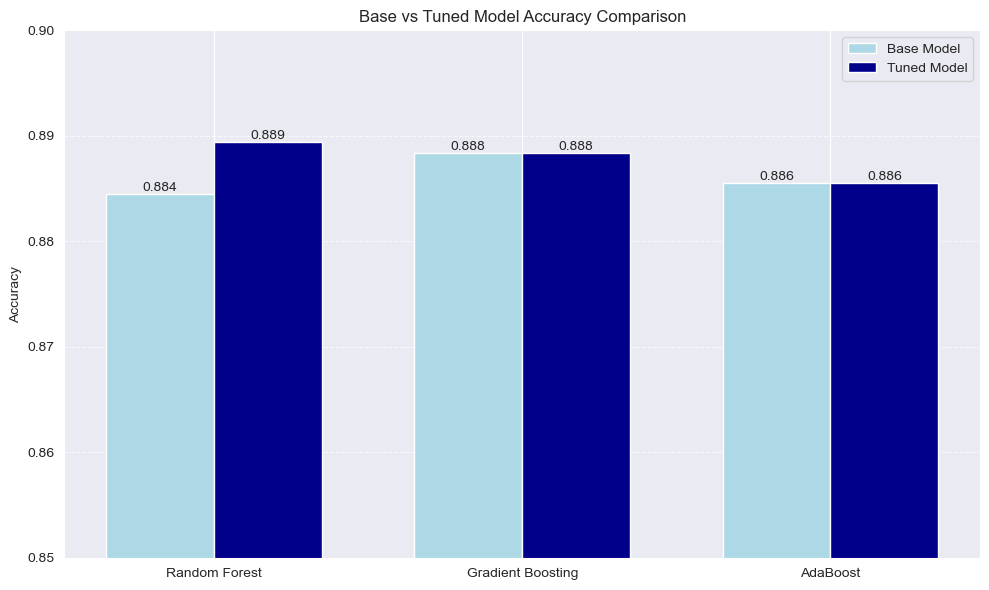

In [9]:
# After the comprehensive comparison, add this code:

# Simple Accuracy Comparison Plot
plt.figure(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

plt.bar(x - width/2, comparison_df['Base Accuracy'], width, label='Base Model', color='lightblue')
plt.bar(x + width/2, comparison_df['Tuned Accuracy'], width, label='Tuned Model', color='darkblue')

plt.ylabel('Accuracy')
plt.title('Base vs Tuned Model Accuracy Comparison')
plt.xticks(x, comparison_df['Model'])
plt.ylim(0.85, 0.90)  # Set y-axis limits to better show differences

# Add value labels on the bars
for i in range(len(x)):
    plt.text(i - width/2, comparison_df['Base Accuracy'][i], 
             f"{comparison_df['Base Accuracy'][i]:.3f}", 
             ha='center', va='bottom')
    plt.text(i + width/2, comparison_df['Tuned Accuracy'][i], 
             f"{comparison_df['Tuned Accuracy'][i]:.3f}", 
             ha='center', va='bottom')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()